# General Process

### 1. Environment  Set up
First  import the depending libraries and the project data


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
import itertools
from itertools import product
from sklearn.model_selection import KFold

%matplotlib inline 


In [185]:
!pip install xgboost

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
     |████████████████████████████████| 675kB 243kB/s eta 0:00:01
  Stored in directory: /Users/futianshu/Library/Caches/pip/wheels/5d/ea/e9/4aef52d7294badf6bc26728a73d3e001c38e07f7dc3722c5eb
Successfully built xgboost
You should consider upgrading via the 'pip install --upgrade pip' command.


In [186]:
from xgboost import XGBRegressor

In [1]:
!ls


Final_Project_Code.ipynb xgb_submission.csv       xgb_test.pickle
data1.pkl                xgb_submission_2.csv     xgb_train.pickle
submission_1.csv         xgb_submission_3.csv
submission_2.csv         xgb_submission_4.csv


### 2. Explore basic info 
Check the basic info of the dataframes

####  2.1Transactions table

In [4]:
len(transactions)

2935849

In [5]:
transactions.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [6]:
transactions.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [7]:
transactions.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

####  2.2Items table

In [8]:
len(items)

22170

In [9]:
items.dtypes

item_name           object
item_id              int64
item_category_id     int64
dtype: object

In [10]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [11]:
items.isnull().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

#### 2.3 item_categories  table

In [12]:
len(item_categories)

84

In [13]:
item_categories.dtypes

item_category_name    object
item_category_id       int64
dtype: object

In [14]:
item_categories.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [15]:
item_categories.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

#### 2.4 shops    

In [17]:
len(shops)

60

In [18]:
shops.dtypes

shop_name    object
shop_id       int64
dtype: object

In [28]:
shops.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

#### 2.5 Check outLiers

Text(0.5,1,'Item_cnt_Distribution')

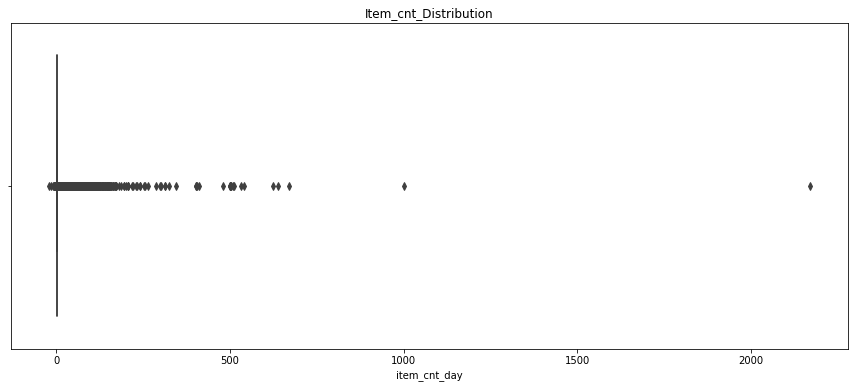

In [70]:
#Check outliers for the "item_cnt_day"
f, ax = plt.subplots(figsize = (15,6))
sns.boxplot(transactions["item_cnt_day"])
plt.title("Item_cnt_Distribution")

In [74]:
#the rate of the cnt bigger than 500
float(len(transactions[transactions["item_cnt_day"]>500]))/float(len(transactions))

4.0874036777777056e-06

Text(0.5,1,'Item_price_Distribution')

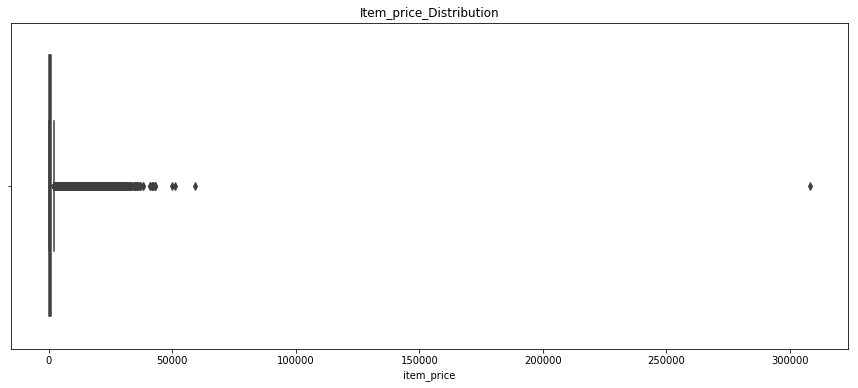

In [69]:
f, ax = plt.subplots(figsize = (15,6))
sns.boxplot(transactions["item_price"])
plt.title("Item_price_Distribution")

In [81]:
len(transactions[transactions["item_price"]>50000])

3

Also, we find a item_price with negative ,which should be an outlier

In [86]:
transactions[transactions["item_price"]<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


By Seeing the distribution, the num item_price over 50000 is `3` , while the num of item_cnt_day over 500 is `12`, i will drop these transations

In [88]:
transactions_droped=transactions[(transactions["item_price"]>0)&(transactions["item_price"]<=50000)&(transactions["item_cnt_day"]<=500)]

After dropping, we had dropped `15` rows of data

In [89]:
len(transactions_copy)-len(transactions_droped)

16

In [100]:
train = transactions_droped

#### Deal with the duplicate shop_id

[Reference](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

In [102]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

/Users/futianshu/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [104]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


#### 2.9 Folowing the steps from kaggle

In [129]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
#shops = shops[['shop_id','city_code']]
cats = item_categories
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [131]:
shops.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [137]:
cats.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [121]:
len(shops)

60

In [119]:
shops.sort_values(by="city_code").head()

,shop_id,city_code
2,2,0
3,3,1
4,4,2
5,5,3
6,6,4


### 3. EDA

#### 3.1 Create datetime 
Add a date time column[Refernce](https://www.geeksforgeeks.org/how-to-filter-dataframe-rows-based-on-the-date-in-pandas/)

In [16]:
#copy the transaction
transactions_copy=transactions
#add the time column
transactions_copy["date_time"]=pd.to_datetime(transactions_copy["date"],format='%d.%m.%Y')
#drop the original date column as we got the new one
transactions_copy=transactions_copy.drop(columns=['date'])
transactions_copy.head(3)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_time
0,0,59,22154,999.0,1.0,2013-01-02
1,0,25,2552,899.0,1.0,2013-01-03
2,0,25,2552,899.0,-1.0,2013-01-05


#### 3.2  Create transactions sale
Since some transactions are return goods, which need to minus

In [17]:
transactions_copy["sales"]=transactions_copy["item_price"]*transactions_copy["item_cnt_day"]
transactions_copy.head(2)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_time,sales
0,0,59,22154,999.0,1.0,2013-01-02,999.0
1,0,25,2552,899.0,1.0,2013-01-03,899.0


In [41]:
#create the total sales of all the shops, sort by sales in desending orders
shop_sales=transactions_copy.groupby("shop_id")["sales"].sum().reset_index().sort_values(by="sales" ,ascending=False)

In [53]:
shop_sales=shop_sales.reset_index()
shop_sales.head(2)

,level_0,index,shop_id,sales
0,0,31,31,2.352170e+08
1,1,25,25,2.164806e+08


Text(0.5,1,'Shop Total Sales')

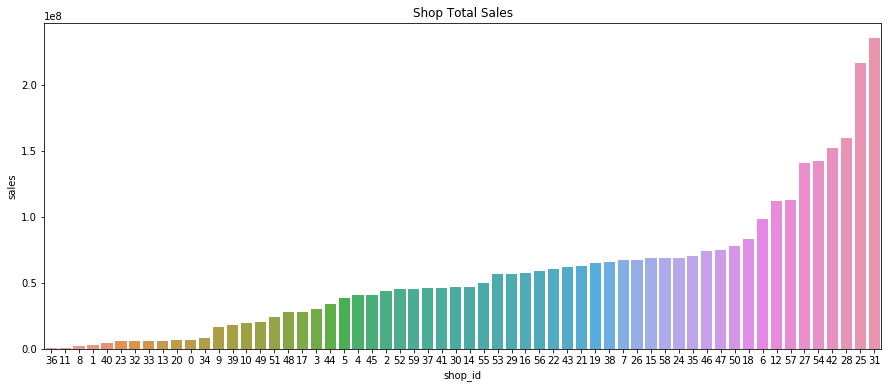

In [73]:
f, ax = plt.subplots(figsize = (15,6))
sns.barplot(x="shop_id",y="sales",data=shop_sales,order=shop_sales.sort_values('sales').shop_id)
plt.title("Shop Total Sales")

#### 3.3  Create year, month, day

- [Pandas – Extract Year from a datetime column](https://datascienceparichay.com/article/pandas-extract-year-from-datetime-column/)

- [Python get weekday](https://www.includehelp.com/python/datetime-weekday-method-with-example.aspx#:~:text=weekday%20%28%29%20Method.%20datetime.weekday%20%28%29%20method%20is%20used,where%20Monday%20is%200%20and%20Sunday%20is%206.)  Note that where Monday is 0 and Sunday is 6. 


In [18]:
transactions_copy["year"]=transactions_copy["date_time"].dt.year
transactions_copy["month"]=transactions_copy["date_time"].dt.month
transactions_copy["day"]=transactions_copy["date_time"].dt.day
transactions_copy["weekday"]=transactions_copy["date_time"].dt.weekday
transactions_copy.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_time,sales,year,month,day,weekday
0,0,59,22154,999.00,1.0,2013-01-02,999.00,2013,1,2,2
1,0,25,2552,899.00,1.0,2013-01-03,899.00,2013,1,3,3
2,0,25,2552,899.00,-1.0,2013-01-05,-899.00,2013,1,5,5
3,0,25,2554,1709.05,1.0,2013-01-06,1709.05,2013,1,6,6
4,0,25,2555,1099.00,1.0,2013-01-15,1099.00,2013,1,15,1


 Check the end transaction date, which end as 2015-10, the range is from 2013-1 to 2015-10 

In [83]:
#ignore 2015 first since 2 month in 2015 is missing
trans_13_14=transactions_copy[transactions_copy["year"]!=2015]

In [89]:
month_salesSum_13_14=trans_13_14.groupby("month")["sales"].sum().reset_index().sort_values(by="sales",ascending=False)

Text(0.5,1,'Sum sales of each month in 2013, 2014')

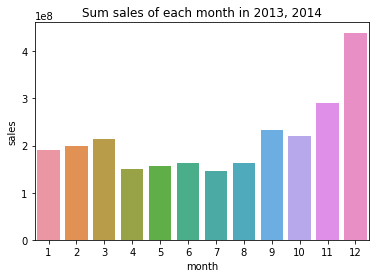

In [92]:
sns.barplot(x='month',y='sales',data=month_salesSum_13_14)
plt.title("Sum sales of each month in 2013, 2014")

In [94]:
weekday_salesSum_13_14_15=transactions_copy.groupby("weekday")["sales"].sum().reset_index().sort_values(by="sales",ascending=False)

In [99]:
weekday_salesSum_13_14_15

,weekday,sales
5,5,6.436678e+08
4,4,5.509652e+08
6,6,5.158628e+08
1,1,4.698721e+08
3,3,4.280627e+08
2,2,4.240947e+08
0,0,3.664011e+08


Text(0.5,1,'Sum of sales in each weekdays')

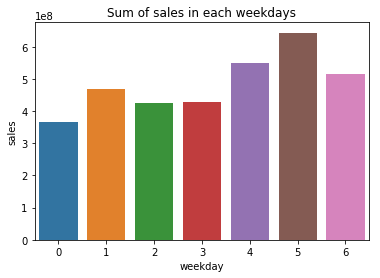

In [97]:
sns.barplot(x='weekday',y='sales',data=weekday_salesSum_13_14_15)
plt.title("Sum of sales in each weekdays")

#### 3.4 Add the category  and item name for each transaction

In [103]:
transactions_copy=transactions_copy.merge(items,left_on='item_id',right_on='item_id')

In [106]:
transactions_copy.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_time,sales,year,month,day,weekday,item_name,item_category_id
0,0,59,22154,999.0,1.0,2013-01-02,999.0,2013,1,2,2,ЯВЛЕНИЕ 2012 (BD),37
1,0,24,22154,999.0,1.0,2013-01-23,999.0,2013,1,23,2,ЯВЛЕНИЕ 2012 (BD),37
2,0,27,22154,999.0,1.0,2013-01-20,999.0,2013,1,20,6,ЯВЛЕНИЕ 2012 (BD),37
3,0,25,22154,999.0,1.0,2013-01-02,999.0,2013,1,2,2,ЯВЛЕНИЕ 2012 (BD),37
4,0,25,22154,999.0,1.0,2013-01-03,999.0,2013,1,3,3,ЯВЛЕНИЕ 2012 (BD),37


In [109]:
sales_by_category=transactions_copy.groupby("item_category_id")["sales"].sum().reset_index().sort_values(by='sales',ascending=False)

In [123]:
sales_by_category["percentage"]=sales_by_category["sales"]/sales_by_category["sales"].sum()*100

In [125]:
sales_by_category.head()

,item_category_id,sales,percentage
19,19,4.120503e+08,12.122954
20,20,3.730103e+08,10.974357
12,12,2.922398e+08,8.598002
23,23,2.596191e+08,7.638269
30,30,2.575193e+08,7.576489


Text(0.5,1,'Total Sales of each category')

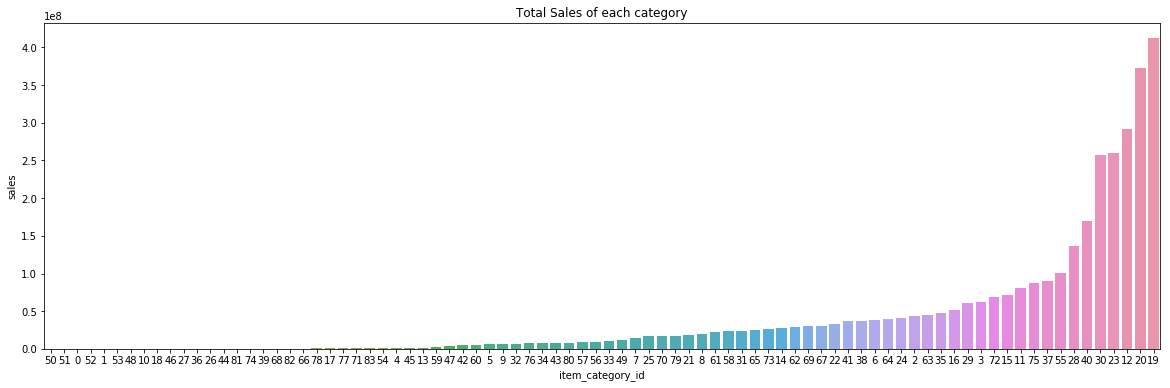

In [117]:
f, ax = plt.subplots(figsize = (20,6))
sns.barplot(x='item_category_id',y='sales',data=sales_by_category,order=sales_by_category.sort_values('sales').item_category_id)
plt.title("Total Sales of each category")

[Tips on build previous price bench mark](https://www.kaggle.com/noahfinberg/eda-previous-value-benchmark) 

[EDA examples](https://www.kaggle.com/kyakovlev/notebooks)

####  4.Build the price bench mark feature

In [19]:
transactions_copy.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_time,sales,year,month,day,weekday
0,0,59,22154,999.00,1.0,2013-01-02,999.00,2013,1,2,2
1,0,25,2552,899.00,1.0,2013-01-03,899.00,2013,1,3,3
2,0,25,2552,899.00,-1.0,2013-01-05,-899.00,2013,1,5,5
3,0,25,2554,1709.05,1.0,2013-01-06,1709.05,2013,1,6,6
4,0,25,2555,1099.00,1.0,2013-01-15,1099.00,2013,1,15,1


In [58]:
# Set up the dataframe for the data processing of this part 
trans_P4 = transactions_copy 

##### Define a serious of function which can user the month i to predict the final result :

In [59]:
# Find the total sailed Count of Each shop i sales for item j in each month 
trans_P4["item_cnt_month"] = trans_P4.groupby(["date_block_num", "shop_id", "item_id"])["item_cnt_day"].transform(np.sum)
# drop the duplicate , after deletion, only shows the total sales count for each month, shop, item
trans_P4 = trans_P4.drop_duplicates(["date_block_num", "shop_id", "item_id"])
#locate the value for the last month, which is Oct 2015
last_month_X = trans_P4[trans_P4["date_block_num"]==32]
#merge the result to the test 
combined = pd.merge(test, last_month_X, on=["shop_id", "item_id"], how="left")
#fill in the na val 
combined = combined.fillna(0)
#clip the result to [0,20]
combined["item_cnt_month"] = combined["item_cnt_month"].clip(upper=20)
#create the submit file 
submission = combined[["ID", "item_cnt_month"]]
submission.head()

,ID,item_cnt_month
0,0,1.0
1,1,0.0
2,2,3.0
3,3,0.0
4,4,0.0


In [60]:
#create the submit file 
submission = combined[["ID", "item_cnt_month"]]
submission.head()

,ID,item_cnt_month
0,0,1.0
1,1,0.0
2,2,3.0
3,3,0.0
4,4,0.0


In [61]:
submission.to_csv("submission_2.csv", index=False)

### 4.  Feature engineering 

In [138]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. This way train data will be similar to test data.

In [5]:
import itertools
from itertools import product

In [139]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

what product in python means : [Iteratate tools: Product ](https://www.geeksforgeeks.org/python-itertools-product/)

### Basic starts

In [2]:
def basic_operations():   
        ts = time.time()
        # read the files
        DATA_FOLDER = '../readonly/final_project_data/'

        transactions    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
        items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
        item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
        shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
        test            = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

        train = transactions
        #Deal with the shops 
        shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
        shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
        shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
        shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
        #shops = shops[['shop_id','city_code']]
        cats = item_categories
        cats['split'] = cats['item_category_name'].str.split('-')
        cats['type'] = cats['split'].map(lambda x: x[0].strip())
        cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
        # if subtype is nan then type
        cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
        cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
        cats = cats[['item_category_id','type_code', 'subtype_code']]

        items.drop(['item_name'], axis=1, inplace=True)

        #creat the matrix , shows all the possible combination of shops and items, since some may not appear in the train set , but showed up in the test set 
        matrix = []
        cols = ['date_block_num','shop_id','item_id']
        for i in range(34):
            sales = train[train.date_block_num==i]
            matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
        matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
        #adjust the num format 
        matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
        matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
        matrix['item_id'] = matrix['item_id'].astype(np.int16)
        matrix.sort_values(cols,inplace=True)
        #add the train revenue 
        train['revenue'] = train['item_price'] *  train['item_cnt_day']
        # Group by month 
        group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
        group.columns=['item_cnt_month']
        #merge the data to the result 
        matrix = pd.merge(matrix, group, on=cols, how='left')
        matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                        .fillna(0)
                                        .clip(0,20) # NB clip target here
                                        .astype(np.float16))
        #applying same things with the test data 
        test['date_block_num'] = 34
        test['date_block_num'] = test['date_block_num'].astype(np.int8)
        test['shop_id'] = test['shop_id'].astype(np.int8)
        test['item_id'] = test['item_id'].astype(np.int16)
        matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
        matrix.fillna(0, inplace=True) # 34 month
        time.time() - ts
        #Shops/Items/Cats features¶
        ts = time.time()
        matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
        matrix = pd.merge(matrix, items, on=['item_id'], how='left')
        matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
        matrix['city_code'] = matrix['city_code'].astype(np.int8)
        matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
        matrix['type_code'] = matrix['type_code'].astype(np.int8)
        matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
        time.time() - ts
        return matrix 





In [8]:
matrix[matrix["item_cnt_month"]!=0].head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_name,city,city_code,item_category_id,type_code,subtype_code
4,0,0,32,6.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,40,11,4
5,0,0,33,3.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,37,11,1
7,0,0,35,1.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,40,11,4
11,0,0,43,1.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,40,11,4
19,0,0,51,2.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,57,13,8


Reference of [numpy.vstack](https://numpy.org/doc/stable/reference/generated/numpy.vstack.html)

In [254]:
group.columns=['item_cnt_month']

In [255]:
matrix = pd.merge(matrix, group, on=cols, how='left')

In [256]:
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

In [257]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


###  Applying the same operations to the test set 

Add the test set info to the matrix  dataframe 

In [258]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [259]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.1538538932800293

### Shops/Items/Cats features

In [260]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts


5.520425081253052

In [262]:
matrix[matrix["date_block_num"]==30].head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_name,city,city_code,item_category_id,type_code,subtype_code
10013504,30,2,30,0.0,0.0,"Адыгея ТЦ ""Мега""",Адыгея,0,40,11,4
10013505,30,2,31,0.0,0.0,"Адыгея ТЦ ""Мега""",Адыгея,0,37,11,1
10013506,30,2,32,0.0,0.0,"Адыгея ТЦ ""Мега""",Адыгея,0,40,11,4
10013507,30,2,33,1.0,0.0,"Адыгея ТЦ ""Мега""",Адыгея,0,37,11,1
10013508,30,2,38,0.0,0.0,"Адыгея ТЦ ""Мега""",Адыгея,0,41,11,35


In [214]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [111]:
basic = basic_operations()

In [112]:
basic.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_name,city,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,40,11,4
1,0,0,27,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,19,5,10
2,0,0,28,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,30,8,55
3,0,0,29,0.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,23,5,16
4,0,0,32,6.0,0.0,"!Якутск Орджоникидзе, 56 фран",Якутск,29,40,11,4


In [113]:
basic_copy = basic.copy()

In [114]:
from sklearn.model_selection import KFold

### Mean encodings

In [115]:
# this function splits the data info k parts,returns the train, test index 
"""
This function splits the data info k parts,returns the train, test index 
In: k: C-v loops num   data: the original data 
Out: tran,test indexes for each C-v
"""
def split_k(k,data):
    ts = time.time()
    kf = KFold(n_splits=k, shuffle=False)
    trainData,testData=[],[]
    for train_index, test_index in kf.split(data):
        trainData.append(train_index)
        testData.append(test_index)
    print("Time cost for split_k: " + str(time.time()-ts))
    return trainData, testData   

In [116]:
"""
Read the train, test Index, data and deal with the cross validation with the target id
Input: train_index, test_index, data , column to aggregate 
Output: data 
"""
def mean_enc(k,train_indexs,test_indexs,data,colName):
    ts =time.time()
    newData = pd.DataFrame()
    for i in range(k):
        #Gets the indexs for the ith C-v 
        train_i_Index, test_i_Index = train_indexs[i], test_indexs[i]
        #get the X trainset, testset 
        train_i,test_i = data.iloc[train_i_Index],data.iloc[test_i_Index]
        #calculate the means by the trainData 
        means =train_i.groupby(colName).item_cnt_month.mean()
        #map the result to the val set and create a column "mean target"
        test_i[colName+"_mean_enc"] = test_i[colName].map(means)
        #fill the NAN 
        test_i[colName+"_mean_enc"].fillna(0.3343, inplace=True)
        # put the test_i to the new data 
        newData=newData.append(test_i)
    print("Time cost for mean_enc: " + str(time.time()-ts))
    return newData
        
    

In [117]:
"""
The sum up function for mean_enc 
In : original data , k, colname
"""
def mean_enc_general(data,k, colName):
    #get the indexs 
    trainIndexLists, testIndexList = split_k(k,data)
    return mean_enc(k,trainIndexLists,testIndexList,data,colName)
    

In [118]:
#add the item_id encode 
newData = mean_enc_general(basic_copy,5,"item_id")

Time cost for split_k: 0.502366065979


/Users/futianshu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Time cost for mean_enc: 9.27660512924


In [119]:
# add the shop_id_encode
newData = mean_enc_general(newData,5,"shop_id")

Time cost for split_k: 0.337862968445


/Users/futianshu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Time cost for mean_enc: 7.03518199921


In [120]:
# mean encode the city_code 
newData = mean_enc_general(newData,5,"city_code")

Time cost for split_k: 0.26571393013


/Users/futianshu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Time cost for mean_enc: 6.81543898582


In [121]:
# mean encode the item_category_id	
newData = mean_enc_general(newData,5,"item_category_id")

Time cost for split_k: 0.265781164169


/Users/futianshu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Time cost for mean_enc: 7.84128904343


In [122]:
# mean encode the type_code 
newData = mean_enc_general(newData,5,"type_code")

Time cost for split_k: 0.288480997086


/Users/futianshu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Time cost for mean_enc: 7.19730615616


In [123]:
# mean encode the subtype_code
newData =  mean_enc_general(newData,5,"subtype_code")

Time cost for split_k: 0.263780117035


/Users/futianshu/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Time cost for mean_enc: 7.591766119


In [124]:
# drop the not used columns
drop_columns = ["ID","shop_name","city","city_code","item_category_id","type_code","subtype_code"]
newData = newData.drop(columns=drop_columns)

In [125]:
newData.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_id_mean_enc,shop_id_mean_enc,city_code_mean_enc,item_category_id_mean_enc,type_code_mean_enc,subtype_code_mean_enc
0,0,0,19,0.0,0.334229,0.334229,0.461426,0.237183,0.208618,0.237183
1,0,0,27,0.0,0.049042,0.334229,0.461426,0.654785,0.629395,0.612793
2,0,0,28,0.0,0.144653,0.334229,0.461426,1.048828,0.567383,1.048828
3,0,0,29,0.0,0.030304,0.334229,0.461426,0.630371,0.629395,0.615234
4,0,0,32,6.0,0.863770,0.334229,0.461426,0.237183,0.208618,0.237183


### Lag features

In [126]:
"""
Caculate the the lag_i features, which means the amount of product of (shopid, itemid) sailed in pr
"""
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [127]:
new_data_lag = lag_feature(newData,[1,2,3,6,12],'item_cnt_month')
new_data_lag= new_data_lag.fillna(0)

In [128]:
new_data_lag.head(5)

,date_block_num,shop_id,item_id,item_cnt_month,item_id_mean_enc,shop_id_mean_enc,city_code_mean_enc,item_category_id_mean_enc,type_code_mean_enc,subtype_code_mean_enc,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,19,0.0,0.334229,0.334229,0.461426,0.237183,0.208618,0.237183,0.0,0.0,0.0,0.0,0.0
1,0,0,27,0.0,0.049042,0.334229,0.461426,0.654785,0.629395,0.612793,0.0,0.0,0.0,0.0,0.0
2,0,0,28,0.0,0.144653,0.334229,0.461426,1.048828,0.567383,1.048828,0.0,0.0,0.0,0.0,0.0
3,0,0,29,0.0,0.030304,0.334229,0.461426,0.630371,0.629395,0.615234,0.0,0.0,0.0,0.0,0.0
4,0,0,32,6.0,0.863770,0.334229,0.461426,0.237183,0.208618,0.237183,0.0,0.0,0.0,0.0,0.0


### Trend

#### Read the transaction files

In [129]:
DATA_FOLDER = '../readonly/final_project_data/'
transactions = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
train = transactions

In [130]:
train = transactions

In [131]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [132]:
#Find the mean price for each products 
group_price_mean = train.groupby(['item_id']).agg({'item_price': ['mean']})

In [133]:
group_price_mean.columns = ['item_avg_item_price']

In [134]:
group_price_mean.reset_index(inplace=True)

In [135]:
new_data_lag = pd.merge(new_data_lag, group_price_mean, on=['item_id'], how='left')

In [136]:
new_data_lag.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_id_mean_enc,shop_id_mean_enc,city_code_mean_enc,item_category_id_mean_enc,type_code_mean_enc,subtype_code_mean_enc,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,item_avg_item_price
0,0,0,19,0.0,0.334229,0.334229,0.461426,0.237183,0.208618,0.237183,0.0,0.0,0.0,0.0,0.0,28.000000
1,0,0,27,0.0,0.049042,0.334229,0.461426,0.654785,0.629395,0.612793,0.0,0.0,0.0,0.0,0.0,1461.228571
2,0,0,28,0.0,0.144653,0.334229,0.461426,1.048828,0.567383,1.048828,0.0,0.0,0.0,0.0,0.0,310.010465
3,0,0,29,0.0,0.030304,0.334229,0.461426,0.630371,0.629395,0.615234,0.0,0.0,0.0,0.0,0.0,1759.285714
4,0,0,32,6.0,0.863770,0.334229,0.461426,0.237183,0.208618,0.237183,0.0,0.0,0.0,0.0,0.0,249.629240


In [138]:
group_price_std = train.groupby(['item_id']).agg({'item_price': ['std']})
group_price_std.columns = ['item_std_item_price']
group_price_std = group_price_std.fillna(0)
group_price_std.reset_index(inplace=True)
new_data_lag = pd.merge(new_data_lag, group_price_std, on=['item_id'], how='left')

In [139]:
# Find the average price of each item in each month(date_block_num)
date_item_avg = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
date_item_avg.columns = ['date_item_avg_item_price']
date_item_avg.reset_index(inplace=True)

In [140]:
new_data_lag = pd.merge(new_data_lag, date_item_avg, on=['date_block_num','item_id'], how='left')

In [142]:
new_data_lag ['date_item_avg_item_price'] = new_data_lag['date_item_avg_item_price'].astype(np.float16)

In [143]:
# calculate the average of this product selled in this shopid of the last 6 months 
lags = [1,2,3,4,5,6]
new_data_lag = lag_feature(new_data_lag, lags, 'date_item_avg_item_price')

In [144]:
new_data_lag.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_id_mean_enc,shop_id_mean_enc,city_code_mean_enc,item_category_id_mean_enc,type_code_mean_enc,subtype_code_mean_enc,...,item_cnt_month_lag_12,item_avg_item_price,item_std_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6
0,0,0,19,0.0,0.334229,0.334229,0.461426,0.237183,0.208618,0.237183,...,0.0,28.000000,0.000000,28.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.049042,0.334229,0.461426,0.654785,0.629395,0.612793,...,0.0,1461.228571,609.841594,2324.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.144653,0.334229,0.461426,1.048828,0.567383,1.048828,...,0.0,310.010465,118.175814,549.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.030304,0.334229,0.461426,0.630371,0.629395,0.615234,...,0.0,1759.285714,612.603954,2398.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,0.863770,0.334229,0.461426,0.237183,0.208618,0.237183,...,0.0,249.629240,99.998174,338.0,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
tmp_copy = new_data_lag

In [146]:
new_data_lag= new_data_lag.fillna(0)

### Sales of the shops 

####  Sum of the total revenue

In [148]:
#create the revenue col
train["revenue"] = train["item_price"]*train["item_cnt_day"]

In [149]:
# sum of the revenue for each months 
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

In [150]:
group.head()

,date_block_num,shop_id,date_shop_revenue
0,0,0,2966412.00
1,0,1,1527320.00
2,0,2,1085064.80
3,0,3,560585.01
4,0,4,1433666.00


In [151]:
new_data_lag = pd.merge(new_data_lag, group, on=['date_block_num','shop_id'], how='left')

In [152]:
#change the data type 
new_data_lag["date_shop_revenue"] = new_data_lag["date_shop_revenue"].astype(np.float32)

#### Mean of the shop revenue

In [153]:
# Find the avg month revenue for each shop id 
group_mean = new_data_lag.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group_mean.columns = ['shop_avg_revenue']
group_mean.reset_index(inplace = True)


In [154]:
group_mean.head()

,shop_id,shop_avg_revenue
0,0,3319831.500
1,1,1619402.250
2,2,1284606.750
3,3,872039.875
4,4,1221477.750


In [155]:
new_data_lag = pd.merge(new_data_lag,group_mean,on=['shop_id'],how='left')

- date_shop_revenue : sum of the shop among all 33 months
-  shop_avg_revenue : avg revenue for shop in month

In [156]:
new_data_lag.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_id_mean_enc,shop_id_mean_enc,city_code_mean_enc,item_category_id_mean_enc,type_code_mean_enc,subtype_code_mean_enc,...,item_std_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,date_shop_revenue,shop_avg_revenue
0,0,0,19,0.0,0.334229,0.334229,0.461426,0.237183,0.208618,0.237183,...,0.000000,28.0,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5
1,0,0,27,0.0,0.049042,0.334229,0.461426,0.654785,0.629395,0.612793,...,609.841594,2324.0,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5
2,0,0,28,0.0,0.144653,0.334229,0.461426,1.048828,0.567383,1.048828,...,118.175814,549.0,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5
3,0,0,29,0.0,0.030304,0.334229,0.461426,0.630371,0.629395,0.615234,...,612.603954,2398.0,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5
4,0,0,32,6.0,0.863770,0.334229,0.461426,0.237183,0.208618,0.237183,...,99.998174,338.0,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5


###  Other special features

In [88]:
new_data_lag.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_id_mean_enc,shop_id_mean_enc,city_code_mean_enc,item_category_id_mean_enc,type_code_mean_enc,subtype_code_mean_enc,...,item_std_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,date_shop_revenue,shop_avg_revenue
0,0,0,19,0.0,0.334229,0.334229,0.461426,0.237183,0.208618,0.237183,...,0.000000,28.0,NaN,NaN,NaN,NaN,NaN,NaN,2966412.0,3319831.5
1,0,0,27,0.0,0.049042,0.334229,0.461426,0.654785,0.629395,0.612793,...,609.841594,2324.0,NaN,NaN,NaN,NaN,NaN,NaN,2966412.0,3319831.5
2,0,0,28,0.0,0.144653,0.334229,0.461426,1.048828,0.567383,1.048828,...,118.175814,549.0,NaN,NaN,NaN,NaN,NaN,NaN,2966412.0,3319831.5
3,0,0,29,0.0,0.030304,0.334229,0.461426,0.630371,0.629395,0.615234,...,612.603954,2398.0,NaN,NaN,NaN,NaN,NaN,NaN,2966412.0,3319831.5
4,0,0,32,6.0,0.863770,0.334229,0.461426,0.237183,0.208618,0.237183,...,99.998174,338.0,NaN,NaN,NaN,NaN,NaN,NaN,2966412.0,3319831.5


####  Features of month

In [157]:
new_data_lag["month"] = (new_data_lag["date_block_num"]+1)%12

In [158]:
new_data_lag.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_id_mean_enc,shop_id_mean_enc,city_code_mean_enc,item_category_id_mean_enc,type_code_mean_enc,subtype_code_mean_enc,...,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,date_shop_revenue,shop_avg_revenue,month
0,0,0,19,0.0,0.334229,0.334229,0.461426,0.237183,0.208618,0.237183,...,28.0,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1
1,0,0,27,0.0,0.049042,0.334229,0.461426,0.654785,0.629395,0.612793,...,2324.0,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1
2,0,0,28,0.0,0.144653,0.334229,0.461426,1.048828,0.567383,1.048828,...,549.0,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1
3,0,0,29,0.0,0.030304,0.334229,0.461426,0.630371,0.629395,0.615234,...,2398.0,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1
4,0,0,32,6.0,0.863770,0.334229,0.461426,0.237183,0.208618,0.237183,...,338.0,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1


In [159]:
"""
Calulate the days in a month 
In: month(int)
Out: num of days in this month 
"""
def days_in_month(month):
    if month<0 or month>12:
        return 
    if month==2:
        return 28
    if month in [1,3,5,7,8,10,12]:
        return 31
    else:
        return 30

In [160]:
new_data_lag["days"] = new_data_lag["month"].apply(lambda x: days_in_month(x))

In [161]:
new_data_lag.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_id_mean_enc,shop_id_mean_enc,city_code_mean_enc,item_category_id_mean_enc,type_code_mean_enc,subtype_code_mean_enc,...,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,date_shop_revenue,shop_avg_revenue,month,days
0,0,0,19,0.0,0.334229,0.334229,0.461426,0.237183,0.208618,0.237183,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31
1,0,0,27,0.0,0.049042,0.334229,0.461426,0.654785,0.629395,0.612793,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31
2,0,0,28,0.0,0.144653,0.334229,0.461426,1.048828,0.567383,1.048828,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31
3,0,0,29,0.0,0.030304,0.334229,0.461426,0.630371,0.629395,0.615234,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31
4,0,0,32,6.0,0.863770,0.334229,0.461426,0.237183,0.208618,0.237183,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31


In [107]:
new_data_lag = new_data_lag.fillna(0,inplace=True)

In [162]:
new_data_lag.columns

Index([u'date_block_num', u'shop_id', u'item_id', u'item_cnt_month',
       u'item_id_mean_enc', u'shop_id_mean_enc', u'city_code_mean_enc',
       u'item_category_id_mean_enc', u'type_code_mean_enc',
       u'subtype_code_mean_enc', u'item_cnt_month_lag_1',
       u'item_cnt_month_lag_2', u'item_cnt_month_lag_3',
       u'item_cnt_month_lag_6', u'item_cnt_month_lag_12',
       u'item_avg_item_price', u'item_std_item_price',
       u'date_item_avg_item_price', u'date_item_avg_item_price_lag_1',
       u'date_item_avg_item_price_lag_2', u'date_item_avg_item_price_lag_3',
       u'date_item_avg_item_price_lag_4', u'date_item_avg_item_price_lag_5',
       u'date_item_avg_item_price_lag_6', u'date_shop_revenue',
       u'shop_avg_revenue', u'month', u'days'],
      dtype='object')

In [163]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

In [164]:
filled_data = fill_na(new_data_lag)

In [166]:
filled_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_id_mean_enc,shop_id_mean_enc,city_code_mean_enc,item_category_id_mean_enc,type_code_mean_enc,subtype_code_mean_enc,...,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,date_shop_revenue,shop_avg_revenue,month,days
0,0,0,19,0.0,0.334229,0.334229,0.461426,0.237183,0.208618,0.237183,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31
1,0,0,27,0.0,0.049042,0.334229,0.461426,0.654785,0.629395,0.612793,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31
2,0,0,28,0.0,0.144653,0.334229,0.461426,1.048828,0.567383,1.048828,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31
3,0,0,29,0.0,0.030304,0.334229,0.461426,0.630371,0.629395,0.615234,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31
4,0,0,32,6.0,0.863770,0.334229,0.461426,0.237183,0.208618,0.237183,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31


In [168]:
# store the data to the file 
filled_data.to_pickle('data1.pkl')

In [169]:
filled_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_id_mean_enc,shop_id_mean_enc,city_code_mean_enc,item_category_id_mean_enc,type_code_mean_enc,subtype_code_mean_enc,...,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6,date_shop_revenue,shop_avg_revenue,month,days
0,0,0,19,0.0,0.334229,0.334229,0.461426,0.237183,0.208618,0.237183,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31
1,0,0,27,0.0,0.049042,0.334229,0.461426,0.654785,0.629395,0.612793,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31
2,0,0,28,0.0,0.144653,0.334229,0.461426,1.048828,0.567383,1.048828,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31
3,0,0,29,0.0,0.030304,0.334229,0.461426,0.630371,0.629395,0.615234,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31
4,0,0,32,6.0,0.863770,0.334229,0.461426,0.237183,0.208618,0.237183,...,0.0,0.0,0.0,0.0,0.0,0.0,2966412.0,3319831.5,1,31


In [177]:
#drop the first 12 months 
filled_data = filled_data[filled_data["date_block_num"]>11]

## XGBOOST 

In [178]:
data = filled_data

In [ ]:
# derop 

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [208]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [209]:
len(X_train),len(X_valid),len(X_test)

(6186922, 238172, 214200)

In [210]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=5,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.12573	validation_1-rmse:1.12297
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08775	validation_1-rmse:1.09142
[2]	validation_0-rmse:1.05752	validation_1-rmse:1.06475
[3]	validation_0-rmse:1.01717	validation_1-rmse:1.04218
[4]	validation_0-rmse:0.992632	validation_1-rmse:1.02483


317.2469689846039

In [211]:
test= pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

In [212]:
import pickle

In [213]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_4.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))